In [66]:
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from tqdm import tqdm
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import tenseal as ts

In [13]:
df = pd.read_csv(r"C:\Users\invite1\Downloads\Manigandan Ramadasan\Code\top_feature_df.csv")
grouped = df.groupby('Label')
df = grouped.apply(lambda x: x.sample(grouped.size().min(), random_state=73).reset_index(drop=True))
x = df.drop(["Label"], axis = 1)
y = df["Label"]
scaler = preprocessing.MinMaxScaler()
# scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)
x_train, x_test_20, y_train, y_test_20 = train_test_split(x, y, test_size=0.20, random_state=42)
x_train=torch.from_numpy(x_train).float()
x_test_20=torch.from_numpy(x_test_20).float()
y_train=torch.from_numpy(np.array(y_train)).float().unsqueeze(1)
y_test_20=torch.from_numpy(np.array(y_test_20)).float().unsqueeze(1)
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test_20.shape}")
print(f"y_test shape: {y_test_20.shape}")

x_train shape: torch.Size([681185, 40])
y_train shape: torch.Size([681185, 1])
x_test shape: torch.Size([170297, 40])
y_test shape: torch.Size([170297, 1])


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [95]:
torch.manual_seed(42)
class NN(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=n_features, out_features=32)
        self.layer_2 = nn.Linear(in_features=32, out_features=16)
        self.layer_3 = nn.Linear(in_features=16, out_features=8)
        self.layer_4 = nn.Linear(in_features=8, out_features=4)
        self.layer_5 = nn.Linear(in_features=4, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer_1(x)
        x = x*x
#         x = self.relu(x)
#         x = torch.sigmoid(x)
        x = self.layer_2(x)
        x = x*x
#         x = self.relu(x)
#         x = torch.sigmoid(x)
        x = self.layer_3(x)
        x = x*x
#         x = self.relu(x)
#         x = torch.sigmoid(x)
        x = self.layer_4(x)
        x = x*x
#         x = self.relu(x)
#         x = torch.sigmoid(x)
        x = self.layer_5(x)
        return x

In [74]:
def train(model, optim, criterion, scheduler, x, y, epochs):
    x, y = x.to(device), y.to(device)
    loss_dict = {}
    for e in range(1, epochs + 1):
        model.train()
        out = model(x)
        loss = loss_fn(out, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        scheduler.step(loss)
        loss_dict[e] = loss.data
        if e%10 == 0:
            print(f"Loss at epoch {e}: {loss.data} || Learning Rate: {optimizer.param_groups[0]['lr']}")
    return model, loss_dict

In [61]:
def accuracy_fn(y_true, y_pred):
    
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct / len(y_pred)) * 100 
    return acc

NN(
  (layer_1): Linear(in_features=40, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=8, bias=True)
  (layer_4): Linear(in_features=8, out_features=4, bias=True)
  (layer_5): Linear(in_features=4, out_features=1, bias=True)
  (relu): ReLU()
)
Loss at epoch 10: 0.6156454682350159
Learning Rate at 10: 0.01
Loss at epoch 20: 0.5991216897964478
Learning Rate at 20: 0.01
Loss at epoch 30: 0.5712631344795227
Learning Rate at 30: 0.01
Loss at epoch 40: 0.502305269241333
Learning Rate at 40: 0.01
Loss at epoch 50: 0.42768627405166626
Learning Rate at 50: 0.01
Loss at epoch 60: 0.37459564208984375
Learning Rate at 60: 0.01
Loss at epoch 70: 0.322366863489151
Learning Rate at 70: 0.01
Loss at epoch 80: 0.292977511882782
Learning Rate at 80: 0.01
Loss at epoch 90: 0.2556629776954651
Learning Rate at 90: 0.01
Loss at epoch 100: 0.23921500146389008
Learning Rate at 100: 0.01
Loss at epoch 110: 0.230710729

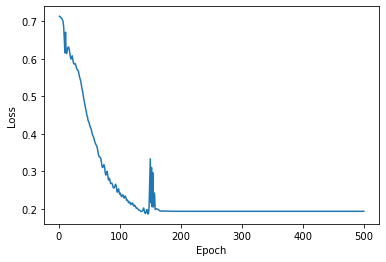

In [96]:
n_features = x_train.shape[1]
model = NN(n_features).to(device)
print(model)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(),  lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)

EPOCH = 500
t_start = time.time()
model, loss_dict = train(model, optimizer, loss_fn, scheduler, x_train, y_train, EPOCH)
t_end = time.time()
print(f"Training Time: {int(t_end - t_start)} seconds")

x_coord, y_coord = zip(*(loss_dict.items()))
plt.plot(x_coord,y_coord)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [97]:
def accuracy(model, x, y):
    t_start = time.time()
    out = torch.sigmoid(model(x))
    t_end = time.time()
    print(f"Prediction Time: {(t_end - t_start)} seconds")
    out_list.append(out)
    correct = torch.abs(y - out) < 0.5
    return correct.float().mean(), out

out_list = []
plain_accuracy, op = accuracy(model, x_test_20, y_test_20)
print(f"Accuracy on plain test_set: {plain_accuracy}")

Prediction Time: 0.02304863929748535 seconds
Accuracy on plain test_set: 0.9423360228538513


In [98]:
op = op.squeeze().detach().numpy()
for i in range(len(op)):
    if op[i]<0.5:
        op[i] = 0
    else:
        op[i] = 1
y_test_temp = y_test_20.squeeze().numpy()
plain_accuracy = accuracy_score(y_test_temp, op)
plain_recall = recall_score(y_test_temp, op, average='binary')  
plain_f1 = f1_score(y_test_temp, op, average='binary')  
plain_precision = precision_score(y_test_temp, op, average='binary')  
print(f"Accuracy: {plain_accuracy}")
print(f"Recall: {plain_recall}")
print(f"Precision: {plain_precision}")
print(f"F1 - Score: {plain_f1}")

Accuracy: 0.9423360364539598
Recall: 0.9719355103862096
Precision: 0.9176284076673208
F1 - Score: 0.9440015510772003
